<a href="https://colab.research.google.com/github/suresha97/MSc_Project/blob/main/DB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#load packages
import scipy
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display
import copy 
import pickle

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import Normalize, Resize, ToTensor
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL
from PIL import Image
import cv2

# Helper Functions

In [19]:
#Function to extract windowed segments of spectrograms
def overlap_windows(data, overlap_rate, window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[:,int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size #start and end overlap 1
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    
    return window_list

def make_data(olr, window_size, augment, fusion):

  #List of strings for each particiapnt
  parts = []
  nums = [str(x) for x in range(1,10,1)]
  ten = ['0'+x for x in nums]
  others = [str(x) for x in range(10,24,1)]
  participants = ten+others

  ppg_full_list = [] # 32 elements of 40 x 80 x 80 arrays
  resp_full_list = []

  #Load spectorgrams of PPG and RESP signals for each particiapnt
  for part in participants: 
    l_ppg = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG_120/ppg_spec_{}_120.npy'.format(part)) #40 x 80 x 80
    l_resp = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/20RESP_120/20resp_spec_{}_120.npy'.format(part)) #40 x 80 x 80 
    
    ppg_full_list.append(l_ppg)
    resp_full_list.append(l_resp)

  ppg_full_array = np.vstack(ppg_full_list)
  resp_full_array = np.vstack(resp_full_list)

  print("PPG:",ppg_full_array.shape)
  print("RESP:",resp_full_array.shape)

  if augment == True:
    #Define resize dimensions for extracted segments
    composed1 = transforms.Compose([ Resize(size=(120,120)),
                                    ToTensor()])

    composed2 = transforms.Compose([ Resize(size=(28,28)),
                                    ToTensor()])
    ppg_aug = []
    resp_aug = []

    #For each sample
    for i in range(len(ppg_full_array)):

      #Extract windowed segemnts for current spectrograms for each signal 
      test_win = overlap_windows(ppg_full_array[i], olr, window_size) 
      test_win2 = overlap_windows(resp_full_array[i], olr, window_size) 
      spec_list = []
      spec_list2 = []

      #Resise current PPG spectrogram segments to 120 x 120 then 28 x 28
      for spec in test_win: 
        out2 = composed1(Image.fromarray(spec))
        out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
        out2 = out2[:,:,0]
        out2 = composed2(Image.fromarray(out2))
        out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
        out2 = out2[:,:,0]
        spec_list.append(out2)

      #Resise current RESP spectrogram segments to 120 x 120 then 28 x 28
      for spec2 in test_win2: 
        out2 = composed1(Image.fromarray(spec2))
        out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
        out2 = out2[:,:,0]
        out2 = composed2(Image.fromarray(out2))
        out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
        out2 = out2[:,:,0]
        spec_list2.append(out2)
      
      ppg_aug.append(np.asarray(spec_list))
      resp_aug.append(np.asarray(spec_list2))

    ppg_aug_array = np.vstack(ppg_aug)
    resp_aug_array = np.vstack(resp_aug)
    print("PPG Augmented :",ppg_aug_array.shape)
    print("RESP Augmented :",resp_aug_array.shape)
    ppg_full_array = ppg_aug_array
    resp_full_array = resp_aug_array

  if fusion == 'two_channel':
    to_stack = [ppg_full_array, resp_full_array]
    two_sig = np.stack(np.asarray(to_stack), axis = 1)
    print("Multi Channel Data:",two_sig.shape)

    return two_sig

  if fusion == 'alpha_blend':
    blend = np.load('/content/drive/My Drive/PHYSIO/spec_alpha_blend.npy')

    if augment == True:
      blend_array = []
      for i in range(len(blend)):

        #Extract windowed segemnts for current spectrograms for each signal 
        test_win = overlap_windows(blend[i], overlap_rate, window_size) 
        spec_list = []

        #Resise current PPG spectrogram segments to 120 x 120 then 28 x 28
        for spec in test_win: 
          out2 = composed1(Image.fromarray(spec))
          out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
          out2 = out2[:,:,0]
          out2 = composed2(Image.fromarray(out2))
          out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
          out2 = out2[:,:,0]
          spec_list.append(out2)

        blend_array.append(np.asarray(spec_list))

      blend_aug = np.vstack(blend_array)
      blend = blend_aug

    print("Alpha-blended Data :",blend.shape)
    return blend

  return ppg_full_array, resp_full_array

def make_labels(file_name,rating,aug_num):
  labels_tdf = pd.read_csv("/content/drive/My Drive/PHYSIO/Generated_Specs/{}.csv".format(file_name)) 
  data_Y = labels_tdf[rating].to_numpy()[0:920]

  #Label encoding for clusterins with quadrant names as labels
  le = preprocessing.LabelEncoder()
  data_Y = le.fit_transform(data_Y)

  #Augment labels to match spectrograms
  aug_labs = []
  for ele in data_Y:
    t_list = [ele]*int(aug_num/920)
    aug_labs.extend(t_list)

  aug_labs = np.asarray(aug_labs)
  print("Labels:",aug_labs.shape)

  return aug_labs


#Accuracy function
def accuracy(features1,features2, labels,task ):
  #Get predictions from model

  outputs = net.forward(features1)
  if task == 'multi':
    outputs = F.softmax(outputs, dim = 0)
    _, preds = torch.max(outputs.data,1)

  if task == 'binary':
    preds = []
    for el in outputs.data:
      if el >= 0.5:
        preds.append(1)
      elif el < 0.5:
        preds.append(0)

  preds = np.array(preds)

  #Find number that are coorect and accuracy
  num_correct = (torch.tensor(preds).int() == labels.int()).sum().numpy()
  accuracy = num_correct/(labels.size()[0])

  return accuracy*100, preds

In [ ]:
ppg_11 = np.split(sub_splits_ppg[0:21], 11)
resp_11 = np.split(sub_splits_resp[0:21], 11)
fold_10 = [x for x in range(1,11,1)]

print(ppg_11.shape)
print(resp_11.shape)
print(fold_11.shape)


# CNN Architecures

In [3]:


class Single_Net(nn.Module):
    
    # Define the neural network layers
    def __init__(self,fcsize,in_channel,num_c1, num_c2,outsize, task):
        
        super(Single_Net, self).__init__()
        self.fcsize = fcsize
        self.task = task
        self.in_channel = in_channel
        self.num_c1 = num_c1
        self.num_c2 = num_c2
        self.outsize = outsize

        #Conv layer
        self.conv1 = nn.Conv2d(self.in_channel, self.num_c1, kernel_size=5)
        self.conv2 = nn.Conv2d(self.num_c1, self.num_c2, kernel_size=5)

        #FC layers
        self.fc1 = nn.Linear(self.fcsize, self.outsize)
        self.fc2 = nn.Linear(self.fcsize*2,1)


    # Define the forward pass.    
    def forward(self, x):
        
        #Conv1 Block 1 - Convolution + Pooling + Non-linearity
        x = F.max_pool2d(self.conv1(x), 2, stride = 2)
        x = F.relu(x)

        #Conv1 Block 2 - Convolution + Pooling + Non-linearity
        x = F.max_pool2d(self.conv2(x), 2, stride = 2)
        x = F.relu(x)

        #Flatten array
        x = x.view(-1, self.fcsize)

        if self.task == 'binary':
          x = torch.sigmoid(self.fc1(x))
        if self.task == 'multi':
          x = self.fc1(x)

        return x

'''For Fusion Method 1 (FUSE 1 )'''
class Multi_Net(nn.Module):
    
    # Define the neural network layers
    def __init__(self,fcsize,in_channel,num_c1, num_c2,outsize,task):
        
        super(Single_Net, self).__init__()
        self.fcsize = fcsize
        self.task = task
        self.in_channel = in_channel
        self.num_c1 = num_c1
        self.num_c2 = num_c2
        self.outsize = outsize

        #Conv layer
        self.conv1 = nn.Conv2d(self.in_channel, self.num_c1, kernel_size=5)
        self.conv2 = nn.Conv2d(self.num_c1, self.num_c2, kernel_size=5)

        #FC layers
        self.fc1 = nn.Linear(self.fcsize, self.outsize)
        self.fc2 = nn.Linear(self.fcsize*2,1)

    # Define the forward pass.    
    
    def forward(self, x, x2):
    
        #Conv1 Block 1 (Singal 1) - Convolution + Pooling + Non-linearity
        x = F.max_pool2d(self.conv1(x), 2, stride = 2)
        x = F.sigmoid(x)
        
        #Conv1 Block 2 (Singal 1) - Convolution + Pooling + Non-linearity
        x = F.max_pool2d(self.conv2(x), 2, stride = 2)
        x = F.sigmoid(x)

        #Conv1 Block 1 (Singal 2) - Convolution + Pooling + Non-linearity
        x2 = F.max_pool2d(self.conv1(x2), 2)
        x2 = F.sigmoid(x2)
        
        #Conv1 Block 2 (Singal 2) - Convolution + Pooling + Non-linearity
        x2 = F.max_pool2d(self.conv2(x2), 2)
        x2 = F.sigmoid(x2)
        
        #Flatten layers for both signal
        x = x.view(-1, self.fcsize)
        x2 = x2.view(-1, self.fcsize)

        #Concatenate features extracted from both spectrograms
        x_combined = torch.cat((x,x2),dim=1)

        #FC layers, non-linearities and predcition layers
        if self.task == 'binary':
          x_combined = torch.sigmoid(self.fc2(x_combined))

        if self.task == 'multi':
          x_combined = self.fc2(x_combined)
        
        return x_combined

# Training Function

In [4]:
# Train the CNN
def train_net(train_set, no_epochs, lr, m, opt, task, fuse):

    #Define tloss functionhe loss
    if task == 'multi':
      loss_func = nn.CrossEntropyLoss()
    if task == 'binary':
      loss_func = nn.BCELoss()

    #Define Optimiser
    if opt == 'ADAM':
      optimizer = optim.AdamW(net.parameters(), lr = lr)
    elif opt == 'SGD':
      optimizer=optim.SGD(net.parameters(), lr = lr, momentum = m, nesterov = True)

    best_val_loss = 10000
    best_epoch = 0
    best_val_acc = 0

    losses_train = []
    losses_val = []

    # Loop over the number of epochs
    for epoch in range(no_epochs):

        #Initialise loss and acc
        current_loss = 0.0
        current_accuracy = 0.0

        # Loop over each mini-batch
        for batch_index, training_batch in enumerate(train_set, 0):
  
            #Load the mini-batch and wrap with variable
            inputs, labels = training_batch
            inputs,  labels = inputs, labels

            if fuse == 1:
              inputs, inputs2, labels = training_batch
              inputs, inputs2, labels = inputs, inputs2, labels

            #Initalise parameter gradients
            optimizer.zero_grad()

            #Forward pass
            outputs = net.forward(inputs)

            if fuse == 1:
              outputs = net.forward(inputs, inputs2)

            if task == 'multi':
              labels = labels.long()

            loss = loss_func(outputs, labels)
            
            #Backward pass
            loss.backward()
            optimizer.step()

            #Add loss 
            current_loss += loss.item()

            #Add accuracy to the overall accuracy
            current_accuracy += accuracy(inputs,'_',labels, task)[0]

            if fuse == 1:
              current_accuracy += accuracy(inputs,inputs2,labels, task)[0]


        test_ac, preds = accuracy(testf_tensor, '_', testl_tensor, task)
        if fuse == 2:
          test_ac, preds = accuracy(testf_tensor, testf_tensor2, testl_tensor, task)

        true_y = testl_tensor.detach().numpy()
        F1_test = sklearn.metrics.f1_score(true_y, preds, average = 'weighted')

        print('[Epoch: %d Batch: %5d] loss: %.3f, acc: %.3f, test_acc:%.3f, F1:%.3f' % (epoch + 1, batch_index+1, current_loss/batchsize, current_accuracy/batchsize, test_ac, F1_test))
        losses_train.append(current_loss/batchsize)

    print("------------------------------------------------------")
    print('Training has finished')

    test_ac, preds = accuracy(testf_tensor, '_', testl_tensor, task)
    if fuse == 2:
      test_ac, preds = accuracy(testf_tensor, testf_tensor2, testl_tensor, task)
    print('Test Accuracy: ',test_ac)

    #Test F1 score
    true_y = testl_tensor.detach().numpy()
    F1_test = sklearn.metrics.f1_score(true_y, preds, average = 'weighted')
    print('Test F1 Score :', F1_test)
    print("All :",sklearn.metrics.classification_report(true_y, preds))
    print("Confusion Matrix :")
    print(sklearn.metrics.confusion_matrix(true_y, preds))
    #sklearn.metrics.plot_confusion_matrix(best_model, testf_tensor)
    
    #Plot learning curves
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(losses_train,'r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return test_ac, F1_test

# Load and make Training Data

In [20]:
#Choose data augmentation parameters for running augment = True
window_size = 40
overlap_rate = 

#Choose clustering strategy and rating to load 
file_n = 'all_labels_threshold_5.0' #all_labels for k-means, all_labels_threshold_5.0 for manual threhsold, class_4 only in all_labels
ratings = 'val3' #val/aro for binary classification, val3/aro3 for multiclass, class_4 for 4 class classification

#Split data by particiapnts for LOSO CV *ALSO NEED FILEN_NAME FOR SPECTROGRAM FILES*
ppg_array, resp_array = make_data(overlap_rate, window_size, augment=True, fusion = None)
sub_splits_ppg = np.split(ppg_array, 23)
sub_splits_resp = np.split(resp_array, 23)

'''For Fusion Method 2 (FUSE 2)'''
two_s = make_data(overlap_rate, window_size, augment=True, fusion ='two_channel')
sub_splits_both = np.split(two_s, 23)

'''For Fusion Method 3 (FUSE 3)'''
alpha_s = make_data(overlap_rate, window_size, augment=True, fusion = 'alpha_blend')
sub_splits_alpha = np.split(alpha_s, 23)

len_aug = len(ppg_array)
labs = make_labels(file_n, ratings, len_aug)
sub_splits_labs = np.split(labs, 23)

print("LOSO Features:",np.asarray(sub_splits_resp).shape)
print("LOSO Features :",np.asarray(sub_splits_both).shape)
print("LOSO Features:",np.asarray(sub_splits_alpha).shape)
print("LOSO Labels:",np.asarray(sub_splits_labs).shape)

#Choose input method (PPG, RESP, FUSE 2, FUSE 3)
dat = sub_splits_both

PPG: (920, 120, 120)
RESP: (920, 120, 120)
PPG Augmented : (2760, 28, 28)
RESP Augmented : (2760, 28, 28)
PPG: (920, 120, 120)
RESP: (920, 120, 120)
PPG Augmented : (2760, 28, 28)
RESP Augmented : (2760, 28, 28)
Multi Channel Data: (2760, 2, 28, 28)
Labels: (2760,)
LOSO Features: (23, 120, 28, 28)
LOSO Features : (23, 120, 2, 28, 28)
LOSO Labels: (23, 120)


# Train Model

Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  1
[Epoch: 1 Batch:   106] loss: 1.088, acc: 35.107, test_acc:30.000, F1:0.310
[Epoch: 2 Batch:   106] loss: 1.086, acc: 38.377, test_acc:30.833, F1:0.322
[Epoch: 3 Batch:   106] loss: 1.084, acc: 36.931, test_acc:28.333, F1:0.302
[Epoch: 4 Batch:   106] loss: 1.081, acc: 38.000, test_acc:27.500, F1:0.299
[Epoch: 5 Batch:   106] loss: 1.079, acc: 36.969, test_acc:30.833, F1:0.322
[Epoch: 6 Batch:   106] loss: 1.077, acc: 39.031, test_acc:30.000, F1:0.316
[Epoch: 7 Batch:   106] loss: 1.075, acc: 39.610, test_acc:26.667, F1:0.278
[Epoch: 8 Batch:   106] loss: 1.075, acc: 38.277, test_acc:25.833, F1:0.267
[Epoch: 9 Batch:   106] loss: 1.073, acc: 37.786, test_acc:21.667, F1:0.223
[Epoch: 10 Batch:   106] loss: 1.071, acc: 39.547, test_acc

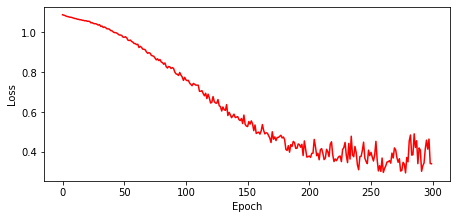

Pre-processing time  validation sets --- 7.185043489933014 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  2
[Epoch: 1 Batch:   106] loss: 1.088, acc: 37.031, test_acc:38.333, F1:0.388
[Epoch: 2 Batch:   106] loss: 1.084, acc: 37.673, test_acc:30.000, F1:0.304
[Epoch: 3 Batch:   106] loss: 1.081, acc: 37.497, test_acc:25.000, F1:0.254
[Epoch: 4 Batch:   106] loss: 1.078, acc: 37.208, test_acc:28.333, F1:0.294
[Epoch: 5 Batch:   106] loss: 1.076, acc: 36.881, test_acc:30.000, F1:0.305
[Epoch: 6 Batch:   106] loss: 1.074, acc: 37.233, test_acc:32.500, F1:0.331
[Epoch: 7 Batch:   106] loss: 1.075, acc: 38.025, test_acc:28.333, F1:0.282
[Epoch: 8 Batch:   106] loss: 1.073, acc: 39.057, test_acc:30.000, F1:0.301
[Epoch: 9 Batch:   106] loss: 1.072, acc: 38.390, test_acc:35.83

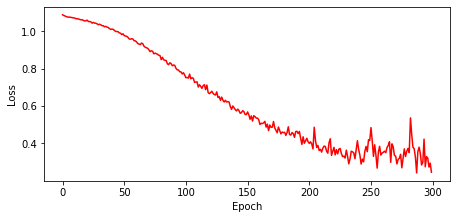

Pre-processing time  validation sets --- 7.140772024790446 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  3
[Epoch: 1 Batch:   106] loss: 1.088, acc: 36.189, test_acc:38.333, F1:0.382
[Epoch: 2 Batch:   106] loss: 1.085, acc: 38.239, test_acc:31.667, F1:0.298
[Epoch: 3 Batch:   106] loss: 1.082, acc: 38.126, test_acc:39.167, F1:0.383
[Epoch: 4 Batch:   106] loss: 1.081, acc: 37.623, test_acc:37.500, F1:0.363
[Epoch: 5 Batch:   106] loss: 1.080, acc: 38.918, test_acc:34.167, F1:0.340
[Epoch: 6 Batch:   106] loss: 1.079, acc: 38.101, test_acc:41.667, F1:0.416
[Epoch: 7 Batch:   106] loss: 1.077, acc: 37.635, test_acc:38.333, F1:0.385
[Epoch: 8 Batch:   106] loss: 1.076, acc: 38.377, test_acc:40.000, F1:0.406
[Epoch: 9 Batch:   106] loss: 1.075, acc: 38.340, test_acc:41.66

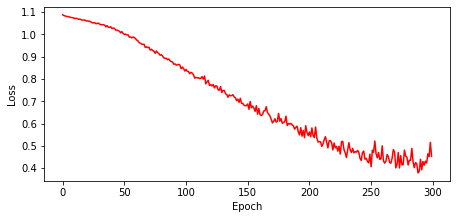

Pre-processing time  validation sets --- 7.102457888921102 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  4
[Epoch: 1 Batch:   106] loss: 1.088, acc: 33.283, test_acc:31.667, F1:0.328
[Epoch: 2 Batch:   106] loss: 1.085, acc: 37.082, test_acc:31.667, F1:0.318
[Epoch: 3 Batch:   106] loss: 1.084, acc: 37.472, test_acc:32.500, F1:0.318
[Epoch: 4 Batch:   106] loss: 1.081, acc: 36.214, test_acc:32.500, F1:0.296
[Epoch: 5 Batch:   106] loss: 1.078, acc: 36.327, test_acc:30.000, F1:0.275
[Epoch: 6 Batch:   106] loss: 1.076, acc: 36.151, test_acc:30.000, F1:0.274
[Epoch: 7 Batch:   106] loss: 1.074, acc: 36.616, test_acc:31.667, F1:0.308
[Epoch: 8 Batch:   106] loss: 1.074, acc: 36.541, test_acc:31.667, F1:0.314
[Epoch: 9 Batch:   106] loss: 1.070, acc: 37.447, test_acc:34.16

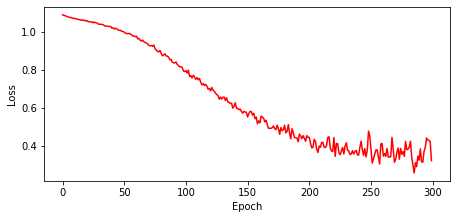

Pre-processing time  validation sets --- 7.148392534255981 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  5
[Epoch: 1 Batch:   106] loss: 1.088, acc: 34.264, test_acc:32.500, F1:0.329
[Epoch: 2 Batch:   106] loss: 1.083, acc: 34.679, test_acc:36.667, F1:0.375
[Epoch: 3 Batch:   106] loss: 1.082, acc: 35.119, test_acc:35.000, F1:0.359
[Epoch: 4 Batch:   106] loss: 1.080, acc: 35.308, test_acc:36.667, F1:0.376
[Epoch: 5 Batch:   106] loss: 1.076, acc: 36.277, test_acc:35.833, F1:0.366
[Epoch: 6 Batch:   106] loss: 1.075, acc: 36.428, test_acc:31.667, F1:0.325
[Epoch: 7 Batch:   106] loss: 1.073, acc: 37.421, test_acc:30.833, F1:0.322
[Epoch: 8 Batch:   106] loss: 1.075, acc: 38.164, test_acc:25.833, F1:0.271
[Epoch: 9 Batch:   106] loss: 1.073, acc: 38.679, test_acc:30.00

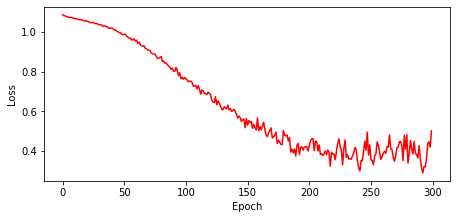

Pre-processing time  validation sets --- 7.159528533617656 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  6
[Epoch: 1 Batch:   106] loss: 1.091, acc: 35.308, test_acc:38.333, F1:0.402
[Epoch: 2 Batch:   106] loss: 1.088, acc: 37.358, test_acc:39.167, F1:0.411
[Epoch: 3 Batch:   106] loss: 1.086, acc: 36.415, test_acc:42.500, F1:0.454
[Epoch: 4 Batch:   106] loss: 1.082, acc: 35.245, test_acc:42.500, F1:0.447
[Epoch: 5 Batch:   106] loss: 1.083, acc: 36.126, test_acc:41.667, F1:0.446
[Epoch: 6 Batch:   106] loss: 1.081, acc: 36.755, test_acc:42.500, F1:0.444
[Epoch: 7 Batch:   106] loss: 1.080, acc: 36.340, test_acc:40.833, F1:0.428
[Epoch: 8 Batch:   106] loss: 1.079, acc: 37.811, test_acc:35.833, F1:0.385
[Epoch: 9 Batch:   106] loss: 1.076, acc: 36.969, test_acc:40.83

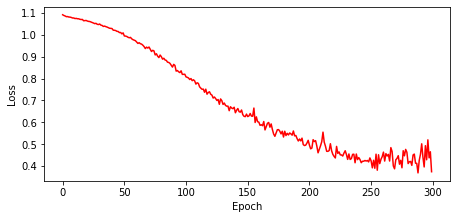

Pre-processing time  validation sets --- 7.102179841200511 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  7
[Epoch: 1 Batch:   106] loss: 1.091, acc: 34.780, test_acc:30.833, F1:0.322
[Epoch: 2 Batch:   106] loss: 1.086, acc: 34.805, test_acc:37.500, F1:0.397
[Epoch: 3 Batch:   106] loss: 1.083, acc: 34.792, test_acc:35.000, F1:0.363
[Epoch: 4 Batch:   106] loss: 1.080, acc: 36.239, test_acc:33.333, F1:0.351
[Epoch: 5 Batch:   106] loss: 1.078, acc: 35.887, test_acc:34.167, F1:0.360
[Epoch: 6 Batch:   106] loss: 1.079, acc: 36.704, test_acc:30.833, F1:0.322
[Epoch: 7 Batch:   106] loss: 1.077, acc: 37.107, test_acc:30.833, F1:0.312
[Epoch: 8 Batch:   106] loss: 1.074, acc: 37.623, test_acc:29.167, F1:0.298
[Epoch: 9 Batch:   106] loss: 1.076, acc: 37.673, test_acc:28.33

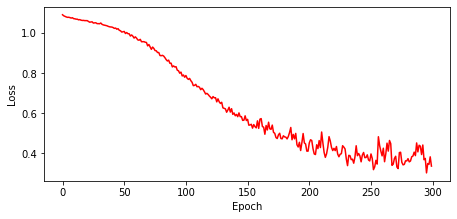

Pre-processing time  validation sets --- 7.1019950866699215 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  8
[Epoch: 1 Batch:   106] loss: 1.087, acc: 34.843, test_acc:41.667, F1:0.422
[Epoch: 2 Batch:   106] loss: 1.083, acc: 35.497, test_acc:36.667, F1:0.374
[Epoch: 3 Batch:   106] loss: 1.078, acc: 34.277, test_acc:35.000, F1:0.356
[Epoch: 4 Batch:   106] loss: 1.077, acc: 35.296, test_acc:34.167, F1:0.340
[Epoch: 5 Batch:   106] loss: 1.076, acc: 36.428, test_acc:33.333, F1:0.328
[Epoch: 6 Batch:   106] loss: 1.074, acc: 36.730, test_acc:40.000, F1:0.391
[Epoch: 7 Batch:   106] loss: 1.071, acc: 37.849, test_acc:30.833, F1:0.299
[Epoch: 8 Batch:   106] loss: 1.069, acc: 37.182, test_acc:35.833, F1:0.353
[Epoch: 9 Batch:   106] loss: 1.068, acc: 38.264, test_acc:36.6

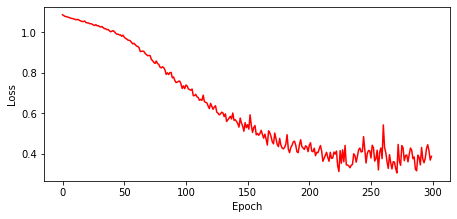

Pre-processing time  validation sets --- 7.118823556105296 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  9
[Epoch: 1 Batch:   106] loss: 1.088, acc: 37.547, test_acc:30.000, F1:0.304
[Epoch: 2 Batch:   106] loss: 1.084, acc: 39.346, test_acc:32.500, F1:0.324
[Epoch: 3 Batch:   106] loss: 1.079, acc: 38.604, test_acc:34.167, F1:0.345
[Epoch: 4 Batch:   106] loss: 1.074, acc: 38.239, test_acc:39.167, F1:0.392
[Epoch: 5 Batch:   106] loss: 1.073, acc: 38.616, test_acc:35.000, F1:0.354
[Epoch: 6 Batch:   106] loss: 1.071, acc: 39.925, test_acc:35.833, F1:0.364
[Epoch: 7 Batch:   106] loss: 1.068, acc: 38.629, test_acc:36.667, F1:0.369
[Epoch: 8 Batch:   106] loss: 1.068, acc: 38.453, test_acc:37.500, F1:0.377
[Epoch: 9 Batch:   106] loss: 1.067, acc: 38.314, test_acc:33.33

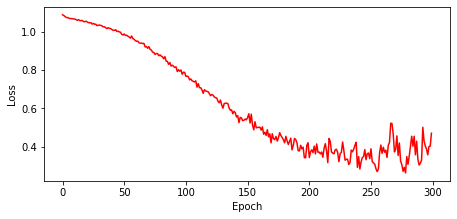

Pre-processing time  validation sets --- 7.057715598742167 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  10
[Epoch: 1 Batch:   106] loss: 1.087, acc: 35.396, test_acc:35.833, F1:0.351
[Epoch: 2 Batch:   106] loss: 1.081, acc: 34.616, test_acc:30.833, F1:0.302
[Epoch: 3 Batch:   106] loss: 1.077, acc: 36.692, test_acc:31.667, F1:0.312
[Epoch: 4 Batch:   106] loss: 1.076, acc: 36.491, test_acc:29.167, F1:0.284
[Epoch: 5 Batch:   106] loss: 1.075, acc: 37.648, test_acc:22.500, F1:0.220
[Epoch: 6 Batch:   106] loss: 1.073, acc: 37.283, test_acc:24.167, F1:0.238
[Epoch: 7 Batch:   106] loss: 1.073, acc: 37.786, test_acc:25.000, F1:0.250
[Epoch: 8 Batch:   106] loss: 1.071, acc: 37.572, test_acc:27.500, F1:0.272
[Epoch: 9 Batch:   106] loss: 1.071, acc: 38.981, test_acc:30.0

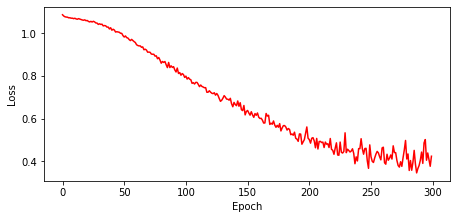

Pre-processing time  validation sets --- 7.1687079787254335 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  11
[Epoch: 1 Batch:   106] loss: 1.090, acc: 36.239, test_acc:33.333, F1:0.311
[Epoch: 2 Batch:   106] loss: 1.081, acc: 34.138, test_acc:30.833, F1:0.272
[Epoch: 3 Batch:   106] loss: 1.080, acc: 35.170, test_acc:31.667, F1:0.303
[Epoch: 4 Batch:   106] loss: 1.077, acc: 34.742, test_acc:38.333, F1:0.375
[Epoch: 5 Batch:   106] loss: 1.075, acc: 35.962, test_acc:37.500, F1:0.366
[Epoch: 6 Batch:   106] loss: 1.074, acc: 36.403, test_acc:33.333, F1:0.327
[Epoch: 7 Batch:   106] loss: 1.073, acc: 38.679, test_acc:36.667, F1:0.348
[Epoch: 8 Batch:   106] loss: 1.073, acc: 38.201, test_acc:34.167, F1:0.343
[Epoch: 9 Batch:   106] loss: 1.068, acc: 39.585, test_acc:31.

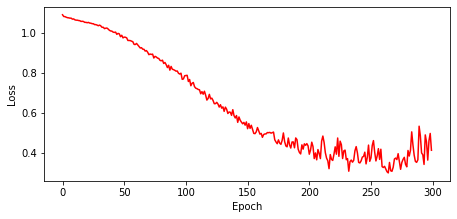

Pre-processing time  validation sets --- 7.121415241559347 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  12
[Epoch: 1 Batch:   106] loss: 1.091, acc: 38.478, test_acc:24.167, F1:0.244
[Epoch: 2 Batch:   106] loss: 1.080, acc: 38.075, test_acc:36.667, F1:0.371
[Epoch: 3 Batch:   106] loss: 1.077, acc: 35.610, test_acc:30.000, F1:0.296
[Epoch: 4 Batch:   106] loss: 1.076, acc: 36.629, test_acc:30.000, F1:0.305
[Epoch: 5 Batch:   106] loss: 1.074, acc: 36.214, test_acc:22.500, F1:0.229
[Epoch: 6 Batch:   106] loss: 1.073, acc: 36.252, test_acc:25.000, F1:0.250
[Epoch: 7 Batch:   106] loss: 1.070, acc: 38.755, test_acc:23.333, F1:0.234
[Epoch: 8 Batch:   106] loss: 1.070, acc: 38.239, test_acc:23.333, F1:0.236
[Epoch: 9 Batch:   106] loss: 1.067, acc: 39.472, test_acc:21.6

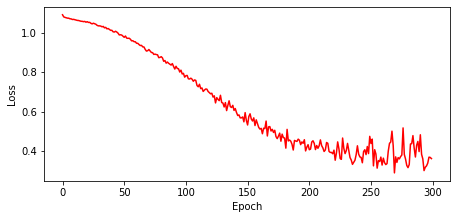

Pre-processing time  validation sets --- 7.1120577176411945 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  13
[Epoch: 1 Batch:   106] loss: 1.086, acc: 37.899, test_acc:30.833, F1:0.304
[Epoch: 2 Batch:   106] loss: 1.080, acc: 36.503, test_acc:36.667, F1:0.358
[Epoch: 3 Batch:   106] loss: 1.079, acc: 32.214, test_acc:36.667, F1:0.360
[Epoch: 4 Batch:   106] loss: 1.078, acc: 35.774, test_acc:40.833, F1:0.395
[Epoch: 5 Batch:   106] loss: 1.077, acc: 34.906, test_acc:39.167, F1:0.386
[Epoch: 6 Batch:   106] loss: 1.075, acc: 35.308, test_acc:39.167, F1:0.378
[Epoch: 7 Batch:   106] loss: 1.074, acc: 35.031, test_acc:35.833, F1:0.357
[Epoch: 8 Batch:   106] loss: 1.072, acc: 36.126, test_acc:40.833, F1:0.408
[Epoch: 9 Batch:   106] loss: 1.070, acc: 36.277, test_acc:36.

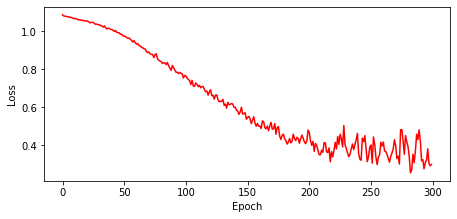

Pre-processing time  validation sets --- 7.049527577559153 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  14
[Epoch: 1 Batch:   106] loss: 1.088, acc: 34.704, test_acc:38.333, F1:0.411
[Epoch: 2 Batch:   106] loss: 1.083, acc: 37.258, test_acc:41.667, F1:0.442
[Epoch: 3 Batch:   106] loss: 1.084, acc: 38.050, test_acc:41.667, F1:0.437
[Epoch: 4 Batch:   106] loss: 1.081, acc: 38.239, test_acc:38.333, F1:0.408
[Epoch: 5 Batch:   106] loss: 1.082, acc: 38.541, test_acc:43.333, F1:0.454
[Epoch: 6 Batch:   106] loss: 1.081, acc: 39.057, test_acc:43.333, F1:0.453
[Epoch: 7 Batch:   106] loss: 1.081, acc: 38.164, test_acc:40.000, F1:0.418
[Epoch: 8 Batch:   106] loss: 1.078, acc: 38.981, test_acc:33.333, F1:0.365
[Epoch: 9 Batch:   106] loss: 1.079, acc: 37.346, test_acc:32.5

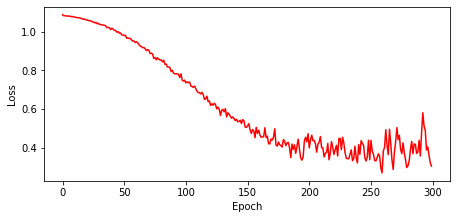

Pre-processing time  validation sets --- 7.148045281569163 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  15
[Epoch: 1 Batch:   106] loss: 1.087, acc: 37.874, test_acc:38.333, F1:0.382
[Epoch: 2 Batch:   106] loss: 1.084, acc: 36.868, test_acc:37.500, F1:0.349
[Epoch: 3 Batch:   106] loss: 1.080, acc: 37.157, test_acc:34.167, F1:0.325
[Epoch: 4 Batch:   106] loss: 1.077, acc: 35.899, test_acc:35.000, F1:0.342
[Epoch: 5 Batch:   106] loss: 1.076, acc: 36.742, test_acc:34.167, F1:0.340
[Epoch: 6 Batch:   106] loss: 1.074, acc: 36.679, test_acc:33.333, F1:0.335
[Epoch: 7 Batch:   106] loss: 1.072, acc: 37.182, test_acc:35.833, F1:0.355
[Epoch: 8 Batch:   106] loss: 1.070, acc: 37.937, test_acc:34.167, F1:0.344
[Epoch: 9 Batch:   106] loss: 1.069, acc: 38.553, test_acc:36.6

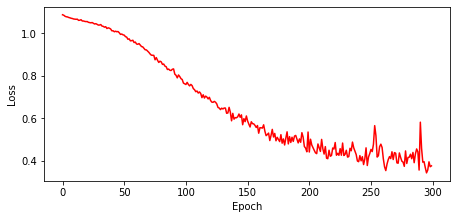

Pre-processing time  validation sets --- 7.129265097777049 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  16
[Epoch: 1 Batch:   106] loss: 1.086, acc: 34.616, test_acc:43.333, F1:0.430
[Epoch: 2 Batch:   106] loss: 1.082, acc: 38.000, test_acc:40.000, F1:0.392
[Epoch: 3 Batch:   106] loss: 1.079, acc: 37.296, test_acc:41.667, F1:0.418
[Epoch: 4 Batch:   106] loss: 1.077, acc: 36.453, test_acc:40.000, F1:0.401
[Epoch: 5 Batch:   106] loss: 1.075, acc: 36.780, test_acc:37.500, F1:0.375
[Epoch: 6 Batch:   106] loss: 1.073, acc: 37.069, test_acc:33.333, F1:0.341
[Epoch: 7 Batch:   106] loss: 1.070, acc: 37.057, test_acc:35.833, F1:0.364
[Epoch: 8 Batch:   106] loss: 1.069, acc: 37.899, test_acc:32.500, F1:0.330
[Epoch: 9 Batch:   106] loss: 1.067, acc: 38.579, test_acc:33.3

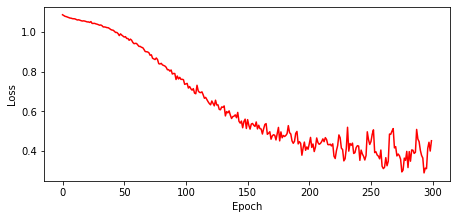

Pre-processing time  validation sets --- 7.02007155418396 minutes ---
Training Features (2640, 2, 28, 28)
Training Labels (2640,)
Training Features (120, 2, 28, 28)
Training Labels (120,)
Trainf torch.Size([2640, 2, 28, 28])
Trainl torch.Size([2640])
Testf torch.Size([120, 2, 28, 28])
Testl torch.Size([120])
Participant :  17
[Epoch: 1 Batch:   106] loss: 1.090, acc: 34.101, test_acc:35.000, F1:0.344
[Epoch: 2 Batch:   106] loss: 1.086, acc: 36.830, test_acc:39.167, F1:0.382
[Epoch: 3 Batch:   106] loss: 1.081, acc: 37.799, test_acc:37.500, F1:0.363
[Epoch: 4 Batch:   106] loss: 1.079, acc: 36.390, test_acc:35.000, F1:0.334
[Epoch: 5 Batch:   106] loss: 1.075, acc: 37.635, test_acc:35.000, F1:0.337
[Epoch: 6 Batch:   106] loss: 1.076, acc: 37.270, test_acc:35.000, F1:0.351
[Epoch: 7 Batch:   106] loss: 1.073, acc: 37.195, test_acc:36.667, F1:0.368
[Epoch: 8 Batch:   106] loss: 1.069, acc: 38.264, test_acc:35.000, F1:0.351
[Epoch: 9 Batch:   106] loss: 1.071, acc: 38.126, test_acc:35.83

In [ ]:
image_size = np.asarray(dat).shape[2]
subjects = [x for x in range(0,23,1)]

accuracies_test = []
f1s = []

#Train model 23 times - differnet particiapnt data each time 
for s in subjects:
  start_time = time.time()

  train_inds = np.where(np.asarray(subjects) != s)[0]
  train_feats = np.take(np.asarray(dat), train_inds, axis = 0)
  train_feats = np.vstack(train_feats)
  
  train_labs = np.take(np.asarray(sub_splits_labs), train_inds, axis = 0)
  train_labs = np.reshape(train_labs, (train_feats.shape[0]))
  print("Training Features",train_feats.shape)
  print("Training Labels",train_labs.shape)

  #Get test fo ld
  test_feats = np.take(np.asarray(dat), s, axis = 0)  
  test_labs = np.take(np.asarray(sub_splits_labs), s, axis = 0)
  test_labs = np.reshape(test_labs, (test_feats.shape[0]))
  print("Training Features",test_feats.shape)
  print("Training Labels",test_labs.shape)

  #Reshape train and test arrays to specify number of input chanenels
  #train_feats = train_feats.reshape(len(train_feats),1,image_size,image_size)
  #test_feats = test_feats.reshape(len(test_feats),1,image_size,image_size)

  #Convert to torch tensors
  trainf_tensor = torch.tensor(train_feats, dtype=torch.float)
  trainl_tensor = torch.tensor(train_labs, dtype=torch.float)
  testf_tensor = torch.tensor(test_feats, requires_grad=False, dtype=torch.float)
 
  testl_tensor = torch.tensor(test_labs, requires_grad=False, dtype=torch.float)
  print("Trainf",trainf_tensor.shape)
  print("Trainl",trainl_tensor.shape)
  print("Testf",testf_tensor.shape)
  print("Testl",testl_tensor.shape)

  ''' For Fusion Method 1 (FUSE 1)'''
  #train_feats2 = np.take(np.asarray(dat2), train_inds, axis = 0)
  #train_feats2 = np.vstack(train_feats2)
  #test_feats2 = np.take(np.asarray(dat2), s, axis = 0)
  #train_feats2 = train_feats.reshape(len(train_feats2),1,image_size,image_size)
  #test_feats2 = test_feats.reshape(len(test_feats2),1,image_size,image_size)
  #trainf_tensor2 = torch.tensor(train_feats2, dtype=torch.float)
  #testf_tensor2 = torch.tensor(test_feats2, requires_grad=False, dtype=torch.float)
  #print("Trainf",trainf_tensor2.shape)

  #Batchify training data using trainloader
  batch_size = 25
  trainset = torch.utils.data.TensorDataset(trainf_tensor, trainl_tensor)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
  batchsize = len(trainloader)

  print("Participant : ",s+1)
  net = Single_Net(fcsize = 288, in_channel = 2, num_c1 = 9, num_c2 = 18, outsize = 3, task = 'multi' )
  #net = Multi_Net(fcsize = 288, in_channel = 1, num_c1 = 9, num_c2 = 18, outsize = 3, task = 'multi' )
  test_accuracy,testf1 = train_net(trainloader, no_epochs = 300, lr = 0.01, m = 0.9, opt = 'SGD', task = 'multi', fuse = None)    
  accuracies_test.append(test_accuracy) 
  f1s.append(testf1)
  print("Pre-processing time  validation sets --- %s minutes ---" % (((time.time() - start_time)/60)))

#Print average metrics across all participants
avg_acc = sum(accuracies_test)/len(accuracies_test)
print("Accuracies :", accuracies_test)
print("Average test accuracy: {}%".format(round(avg_acc,2)))
print("Average test F1 Score :", sum(f1s)/len(f1s))